In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import mdtraj as md
import mcg
import h5py
import pandas as pd

import matplotlib_config as cfg
import fnmatch
from matplotlib import cm as cmpl
from matplotlib.colors import PowerNorm

from cmap import Colormap
import cmasher as cmr
import matplotlib.colors as mcolors 

In [2]:
#Colormap insanity

#cm = cmr.sapphire_r
#cm = Colormap('crameri:tofino')
cm = Colormap('crameri:lipari')
#cm = Colormap('crameri:batlowk')
#cm = Colormap('contrib:araucaria')
#cm = Colormap('colorcet:CET_I3')
#cm = Colormap('cmocean:dense')
#cm = Colormap('cmocean:curl_pink')
#cm = Colormap('crameri:romaO')

mpl_cm = cm.to_mpl().reversed()

cmap_colors = mpl_cm(np.linspace(0, 1, 256))

truncate_point = 0.1

truncated_colors = cmap_colors[int(256 * truncate_point):]
cmap = mcolors.LinearSegmentedColormap.from_list('truncated_cmap', truncated_colors)

In [3]:
step2us = 2e-9
burst = 1e5

grade_burst = 10

In [4]:
datafolders =['data_mu175_chain0_batch_0/']
#folder = 'archive/wrong_wrapping/data_mu180'
gro_folder = 'gro_files'

In [5]:
top_file = os.path.join(gro_folder, 'conf.gro')

In [6]:
def build_pd(run_folder_path):
    logfile_path = os.path.join(run_folder_path, 'log.txt')
    weights = np.load(os.path.join(run_folder_path, 'trajectory_weights.npy'))[1:]
    
    # Load the log file
    df = pd.read_fwf(
        logfile_path,
        header=0,
        widths=[21] * 7,
        strip=True
    )
    df.columns = df.columns.str.strip()
    
    # Initialize weights column with zeros
    df['Weights'] = 0.0
    
    # Get successful rows
    successful_indices = df[df['Successful'] == True].index
    
    # Sanity check
    assert len(successful_indices) == len(weights), "Mismatch between successful trajectories and weights"
    
    # Assign weights to successful trajectories
    for idx, weight in zip(successful_indices, weights):
        df.at[idx, 'Weights'] = weight

    return df

In [7]:

# Dictionary to store all run data
run_data = {}

for datafolder in datafolders:
    print(datafolder)
    run_data[datafolder] = {}
    
    for run_folder in os.listdir(datafolder):
        run_folder_path = os.path.join(datafolder, run_folder)
        
        # Skip non-directories and hidden folders
        if not os.path.isdir(run_folder_path) or run_folder.startswith('.'):
            continue
        
        # Initialize entry for this run
        run_data[datafolder][run_folder] = {
            'log': None,
            'index_succ': {},
            'trial_rej': {},
            'cages': {}
        }
        
        df = build_pd(run_folder_path)
        run_data[datafolder][run_folder]['log'] = df
        
        # Process successful trials
        for succ_file in os.listdir(run_folder_path):
            if succ_file.startswith('cv_') and not succ_file.endswith('_0.txt'):
                try:
                    trial_num = int(succ_file.split('_')[1].split('.')[0])
                    trial_path = os.path.join(run_folder_path, succ_file)
                    frames, mcg_values = np.loadtxt(trial_path, skiprows=1, unpack=True)

                    cutoff_mask = mcg_values >= 300
                    B_cutoff = int(frames[np.argmax(cutoff_mask)] / burst) if np.any(cutoff_mask) else None

                    run_data[datafolder][run_folder]['index_succ'][trial_num] = {
                        'frames': frames,
                        'mcg_values': mcg_values,
                        'B_cutoff': B_cutoff,
                        'file_path': os.path.join(run_folder_path, f'traj_{trial_num}.dcd')
                    }

                    parts = ['cages']
                    parts.extend(datafolder.split('_')[1:])
                    cagefolder = '_'.join(parts)

                    
                    try:
                        times, _, Cages_512, Cages_62512, Cages_64512, Cages_4151062, _ = np.loadtxt(f'{cagefolder}/{run_folder}/traj_{trial_num}_stride_10_grade.txt', skiprows = 1, unpack = True)
    
                        run_data[datafolder][run_folder]['cages'][trial_num] = {
                        'frames': times,
                        '512': Cages_512,
                        '62512': Cages_62512,
                        '64512': Cages_64512,
                        '4151062': Cages_4151062
                        }
                    except Exception as cage_error:
                        print(f"Cage data not available for trial {trial_num} in {run_folder}: {cage_error}")
                    

                except (ValueError, IndexError) as e:
                    print(f"Error processing {succ_file} in {run_folder}: {e}")
                    continue
                
    
        
        # Process rejected trials
        for rej_file in os.listdir(run_folder_path):
            if rej_file.startswith('rejected_cv_trial_') and not rej_file.endswith('_0.txt'):
                try:
                    trial_num = int(rej_file.split('_')[3].split('.')[0])
                    trial_path = os.path.join(run_folder_path, rej_file)
                    frames, mcg_values = np.loadtxt(trial_path, skiprows=1, unpack=True)

                    run_data[datafolder][run_folder]['trial_rej'][trial_num] = {
                        'frames': frames,
                        'mcg_values': mcg_values
                    }

                except (ValueError, IndexError) as e:
                    print(f"Error processing {rej_file} in {run_folder}: {e}")
                    continue
        


data_mu175_chain0_batch_0/


## RESAMPLING

In [8]:
# make list of all trajectories 

all_trajectories_list = []

for dataset in run_data:
    for run in run_data[dataset]:
        all_trajectories_list.append((dataset, run))

# make list of all weights in this order

# resample this list

#this list serves as a way to extract traj from dict

## CAGE COUNT PLOTS

In [9]:
cage_ratios = []
cages_62512 = []
cages_4151062 = []

cage_ratios_halfway = []
cages_4_halfway = []
cages_5_halfway = []

for dataset in run_data:
    for run in run_data[dataset]:
    
        #print(successful_df)
    
        for idx in run_data[dataset][run]['cages'].keys():
            
            frames = run_data[dataset][run]['cages'][idx]['frames']
            #print(frames)
            Cages_512 = run_data[dataset][run]['cages'][idx]['512']
            Cages_62512 = run_data[dataset][run]['cages'][idx]['62512']
            Cages_64512 = run_data[dataset][run]['cages'][idx]['64512']
            Cages_4151062 = run_data[dataset][run]['cages'][idx]['4151062']
    
            cage_ratio = Cages_62512[-1] / Cages_4151062[-1]
    
            N = len(frames)
    
            cage_ratios.append(cage_ratio)
            cages_62512.append(Cages_62512[-1])
            cages_4151062.append(Cages_4151062[-1])
    
            cage_ratios_halfway.append(Cages_62512[N // 2] / Cages_4151062[N // 2])
            cages_4_halfway.append(Cages_4151062[N // 2])
            cages_5_halfway.append(Cages_62512[N // 2])
            
    
            '''plt.plot(frames * step2us, Cages_512, label = '512', c=cfg.colors['lightblue'])
            plt.plot(frames * step2us, Cages_62512, label = '62512', c=cfg.colors['purple'])
            plt.plot(frames * step2us, Cages_64512, label = '64512', c=cfg.colors['red'])
            plt.plot(frames * step2us, Cages_4151062, label = '4151062', c=cfg.colors['lightgreen'])'''
            #plt.scatter(sp_idx * step2us, sp_cv, zorder = 100, c = 'black')
            #c += 1
            #plt.show()

'''#plt.legend()
plt.xlabel('time ($\mu s$)')
plt.ylabel('Cage Number')'''

/scratch_local/ipykernel_2356864/3802413003.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  cage_ratios_halfway.append(Cages_62512[N // 2] / Cages_4151062[N // 2])


"#plt.legend()\nplt.xlabel('time ($\\mu s$)')\nplt.ylabel('Cage Number')"

In [10]:
x = np.arange(50)

In [11]:
#n = len(successful_trajs)
#colors_mpl = cm.tab20(np.linspace(0, 1, n))
#c = 0

cage_ratios = []
cages_62512 = []
cages_4151062 = []

cage_ratios_halfway = []
cages_4_halfway = []
cages_5_halfway = []

cages_62512_traj = []


cage_ratio_traj = []
mcg_traj = []

all_Cages_62512 = []
all_Cages_4151062 = []

for dataset in run_data:
    for run in run_data[dataset]:
    
        #print(successful_df)
    
        for idx in run_data[dataset][run]['cages'].keys():
    
            mcg_values = run_data[dataset][run]['index_succ'][idx]['mcg_values']
            mcg_values_cut = mcg_values[::100]
    
            cutoff_mask = mcg_values_cut >= 300
    
            frames = run_data[dataset][run]['cages'][idx]['frames']
    
        
            if np.any(cutoff_mask):
                B_cutoff = np.argmax(cutoff_mask)
            else:
                B_cutoff = len(frames) - 1  # or -1 or np.nan if you prefer a sentinel value
            
            mcg_values_cut = mcg_values_cut[: B_cutoff +1]
            
            Cages_512 = run_data[dataset][run]['cages'][idx]['512']
            Cages_62512 = run_data[dataset][run]['cages'][idx]['62512']
            Cages_64512 = run_data[dataset][run]['cages'][idx]['64512']
            Cages_4151062 = run_data[dataset][run]['cages'][idx]['4151062']


            all_Cages_62512.append(Cages_62512)
            all_Cages_4151062.append(Cages_4151062)
            
            frames_cutoff = frames[: B_cutoff +1]
    
            mcg_traj.append(mcg_values_cut)
        
    
            cage_ratio = Cages_62512[-1] / Cages_4151062[-1]
            cage_ratio_frames = Cages_62512 / Cages_4151062

            total_cage_count_frames = Cages_512 + Cages_62512 + Cages_64512 + Cages_4151062

            if cage_ratio < 1:
                structure = 'amorphous'
            if cage_ratio >= 1:
                structure = 'crystalline'
    
            run_data[dataset][run]['index_succ'][idx]['CageRatio'] = cage_ratio
            run_data[dataset][run]['index_succ'][idx]['CageRatioFrames'] = cage_ratio_frames
            run_data[dataset][run]['index_succ'][idx]['Structure'] = structure
            run_data[dataset][run]['index_succ'][idx]['CageCount'] = total_cage_count_frames
            
            cage_ratio_traj.append( Cages_62512 / Cages_4151062 )
            #print(cage_ratio_traj)
            
    
            N = len(frames)
    
            cage_ratios.append(cage_ratio)
            cages_62512.append(Cages_62512[-1])
            cages_4151062.append(Cages_4151062[-1])
    
            cages_62512_traj.append(Cages_62512)
    

/scratch_local/ipykernel_2356864/924680984.py:59: RuntimeWarning: invalid value encountered in divide
  cage_ratio_frames = Cages_62512 / Cages_4151062
/scratch_local/ipykernel_2356864/924680984.py:73: RuntimeWarning: invalid value encountered in divide
  cage_ratio_traj.append( Cages_62512 / Cages_4151062 )
/scratch_local/ipykernel_2356864/924680984.py:59: RuntimeWarning: divide by zero encountered in divide
  cage_ratio_frames = Cages_62512 / Cages_4151062
/scratch_local/ipykernel_2356864/924680984.py:73: RuntimeWarning: divide by zero encountered in divide
  cage_ratio_traj.append( Cages_62512 / Cages_4151062 )


## ONLY ENDPOINTS

In [12]:
cm_name = 'crameri:acton'
cm_name = 'crameri:lipari'
cm_name = 'seaborn:rocket'
#cm_name = 'colorbrewer:YlGnBu_9'


cm = Colormap(f'{cm_name}')
mpl_cm = cm.to_mpl().reversed()

cmap_colors = mpl_cm(np.linspace(0, 1, 256))
truncate_point = 0.2

truncated_colors = cmap_colors[int(256 * truncate_point):]
cmap = mcolors.LinearSegmentedColormap.from_list('truncated_cmap', truncated_colors)

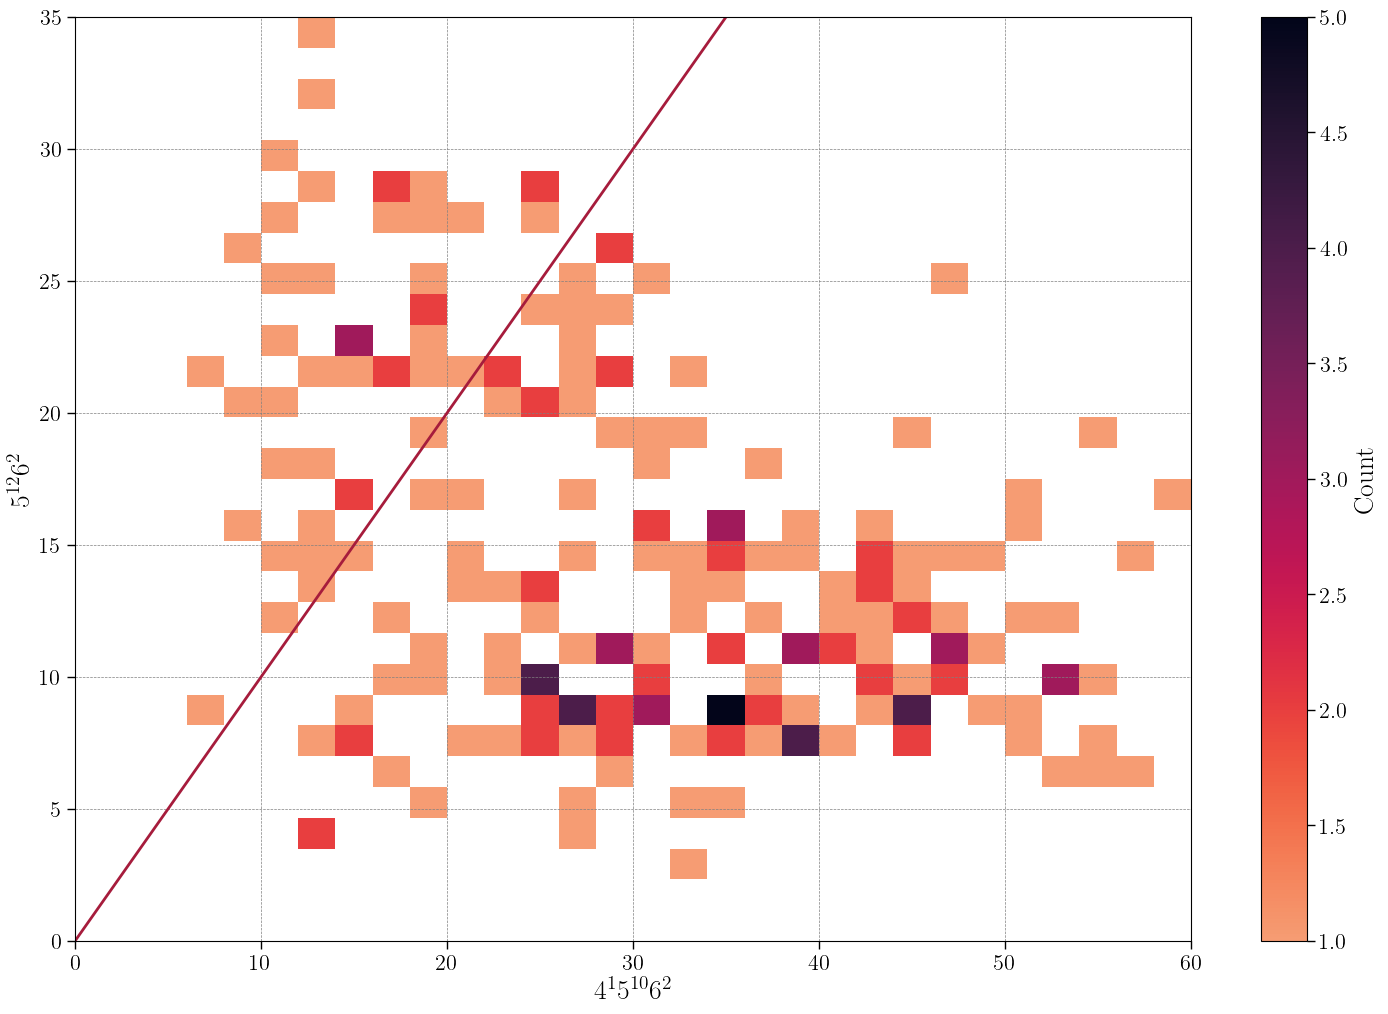

In [13]:
plt.figure(figsize=(18, 12))

counts, xedges, yedges = np.histogram2d(
    cages_4151062,
    cages_62512,
    bins=30,
    range=[[0, 60], [0, 35]]
)

masked_counts = np.ma.masked_where(counts == 0, counts)
X, Y = np.meshgrid(xedges, yedges, indexing="ij")

plt.pcolormesh(X, Y, masked_counts, cmap=cmap)
plt.plot(x, x, color=cfg.colors['red'])
plt.colorbar(label='Count')
plt.xlabel(r'$4^15^{10}6^2$')
plt.ylabel(r'$5^{12}6^2$')
plt.xlim(0, 60)
plt.ylim(0, 35)
plt.savefig('figures/structure_analysis_histogram.png')
plt.show()


## SAVING LISTS OF AMORPHOUS/CRYSTALLINE TRAJECTORIES

In [14]:
crystalline_trajectories = []
amorphous_trajectories = []


for dataset in run_data:
    for run in run_data[dataset]:
        #print(dataset)
    
        #print(successful_df)
    
        for idx in run_data[dataset][run]['index_succ'].keys():
            structure = run_data[dataset][run]['index_succ'][idx]['Structure']
            #print(structure)
            if structure == 'crystalline':
                traj_path = run_data[dataset][run]['index_succ'][idx]['file_path']
                crystalline_trajectories.append(traj_path)

            else:
                traj_path = run_data[dataset][run]['index_succ'][idx]['file_path']
                amorphous_trajectories.append(traj_path)
        

## FULL TRAJECTORIES

In [15]:
all_Cages_4151062_flattened = [item for sublist in all_Cages_4151062 for item in sublist]
all_Cages_62512_flattened = [item for sublist in all_Cages_62512 for item in sublist]


In [16]:
cm_name = 'crameri:acton'
cm_name = 'seaborn:rocket'


cm = Colormap(f'{cm_name}')
mpl_cm = cm.to_mpl().reversed()

cmap_colors = mpl_cm(np.linspace(0, 1, 256))
truncate_point = 0.1

truncated_colors = cmap_colors[int(256 * truncate_point):]
cmap = mcolors.LinearSegmentedColormap.from_list('truncated_cmap', truncated_colors)

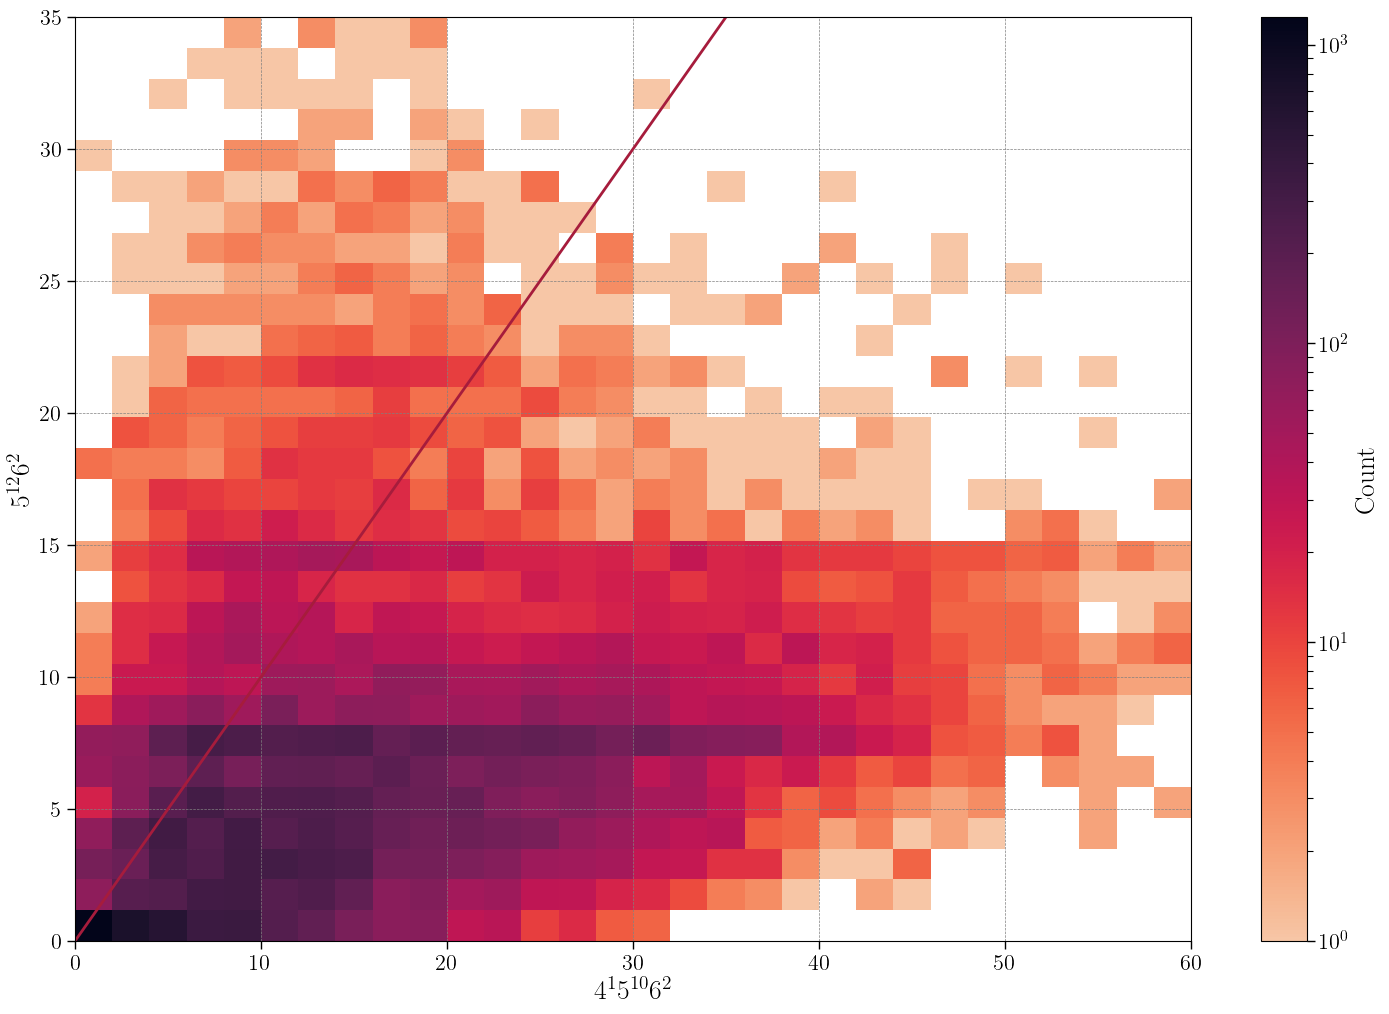

In [17]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(18, 12))

counts, xedges, yedges = np.histogram2d(
    all_Cages_4151062_flattened,
    all_Cages_62512_flattened,
    bins=30,
    range=[[0, 60], [0, 35]]
)

masked_counts = np.ma.masked_where(counts == 0, counts)
X, Y = np.meshgrid(xedges, yedges, indexing="ij")

plt.pcolormesh(X, Y, masked_counts, cmap=cmap, norm=LogNorm())
plt.plot(x, x, color=cfg.colors['red'])
plt.colorbar(label='Count')
plt.xlabel(r'$4^15^{10}6^2$')
plt.ylabel(r'$5^{12}6^2$')
#plt.xlim(0, 60)
plt.ylim(0, 35)
plt.savefig('figures/structure_analysis_histogram_full_traj.png')
plt.show()


In [18]:
mcg_all_frames = []
cr_all_frames = []
CageCount_frames = []

for run_idx in range(12):
    CR_list = []
    run = f'run_{run_idx}'
    for dataset in run_data:
        #print(dataset)
        for idx in run_data[dataset][run]['index_succ'].keys():
            
            CR = run_data[dataset][run]['index_succ'][idx]['CageRatioFrames']

            frames = run_data[dataset][run]['index_succ'][idx]['frames']
            mcg_values = run_data[dataset][run]['index_succ'][idx]['mcg_values'][::grade_burst]

            CageCount = run_data[dataset][run]['index_succ'][idx]['CageCount']


            if len(CR) != len(mcg_values):
                raise IndexError(f'Must have same length! CR {len(CR)} MCG {len(mcg_values)} {CR} {mcg_values}  {dataset} {run} {idx}')
                continue
                
            else: 
                cr_all_frames.extend(CR)
                mcg_all_frames.extend(mcg_values)
                CageCount_frames.extend(CageCount)


cr_mcg = np.vstack((mcg_all_frames, cr_all_frames))
mask = ~(np.isnan(cr_mcg[1, :]) | np.isinf(cr_mcg[1, :]))
clean_cr_mcg = cr_mcg[:, mask]

In [19]:
clean_cr_mcg[0, :]

array([ 33.,  36.,  47., ..., 268., 297., 268.])

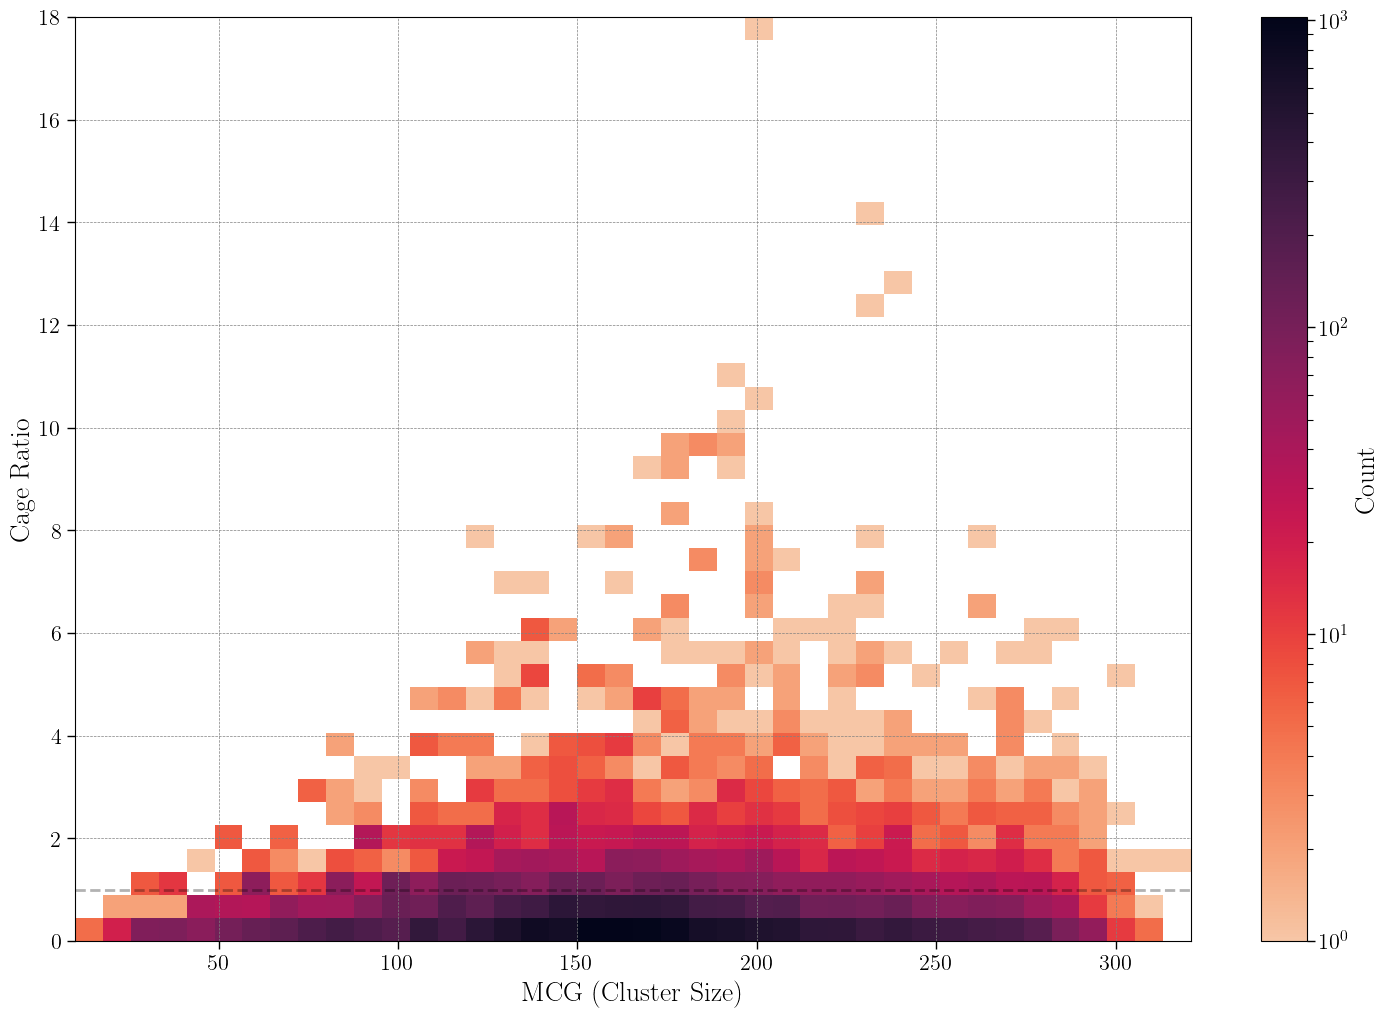

In [20]:
plt.figure(figsize=(18, 12))

counts, xedges, yedges = np.histogram2d(
    clean_cr_mcg[0, :],
    clean_cr_mcg[1, :],
    bins=40
    #range=[[0, 60], [0, 35]]
)

#masked_counts = np.ma.masked_where(counts == 0, counts)
X, Y = np.meshgrid(xedges, yedges, indexing="ij")

plt.axhline(y=1, color='k', linestyle='--', alpha=0.3)

plt.pcolormesh(X, Y, counts, cmap=cmap, norm=LogNorm())
#plt.plot(x, x, color=cfg.colors['red'])
plt.colorbar(label='Count')
plt.xlabel(r'MCG (Cluster Size)')
plt.ylabel(r'Cage Ratio')
#plt.xlim(0, 60)
#plt.ylim(0, 35)
plt.savefig('figures/cr_vs_mcg.png')
plt.show()

In [21]:
counts_CageCount, xedges, yedges = np.histogram2d(
    cr_mcg[0, :],
    CageCount_frames,
    bins=40
    #range=[[0, 60], [0, 35]]
)

In [22]:
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
xcenters = 0.5 * (xedges[:-1] + xedges[1:])

weighted_cage_sum = np.sum(counts_CageCount * ycenters[np.newaxis, :], axis=1)

total_counts = np.sum(counts_CageCount, axis=1)

with np.errstate(divide='ignore', invalid='ignore'): #safe division
    avg_cage_per_mcg = np.divide(weighted_cage_sum, total_counts)
    avg_cage_per_mcg = np.nan_to_num(avg_cage_per_mcg) 

In [23]:
plt.rcParams.update({
    'font.size': 18,
    'axes.labelsize': 40,
    'axes.titlesize': 18,
    'xtick.labelsize': 40,
    'ytick.labelsize': 40,
    'legend.fontsize': 35,
    'legend.frameon': False,
    'axes.grid': True
})

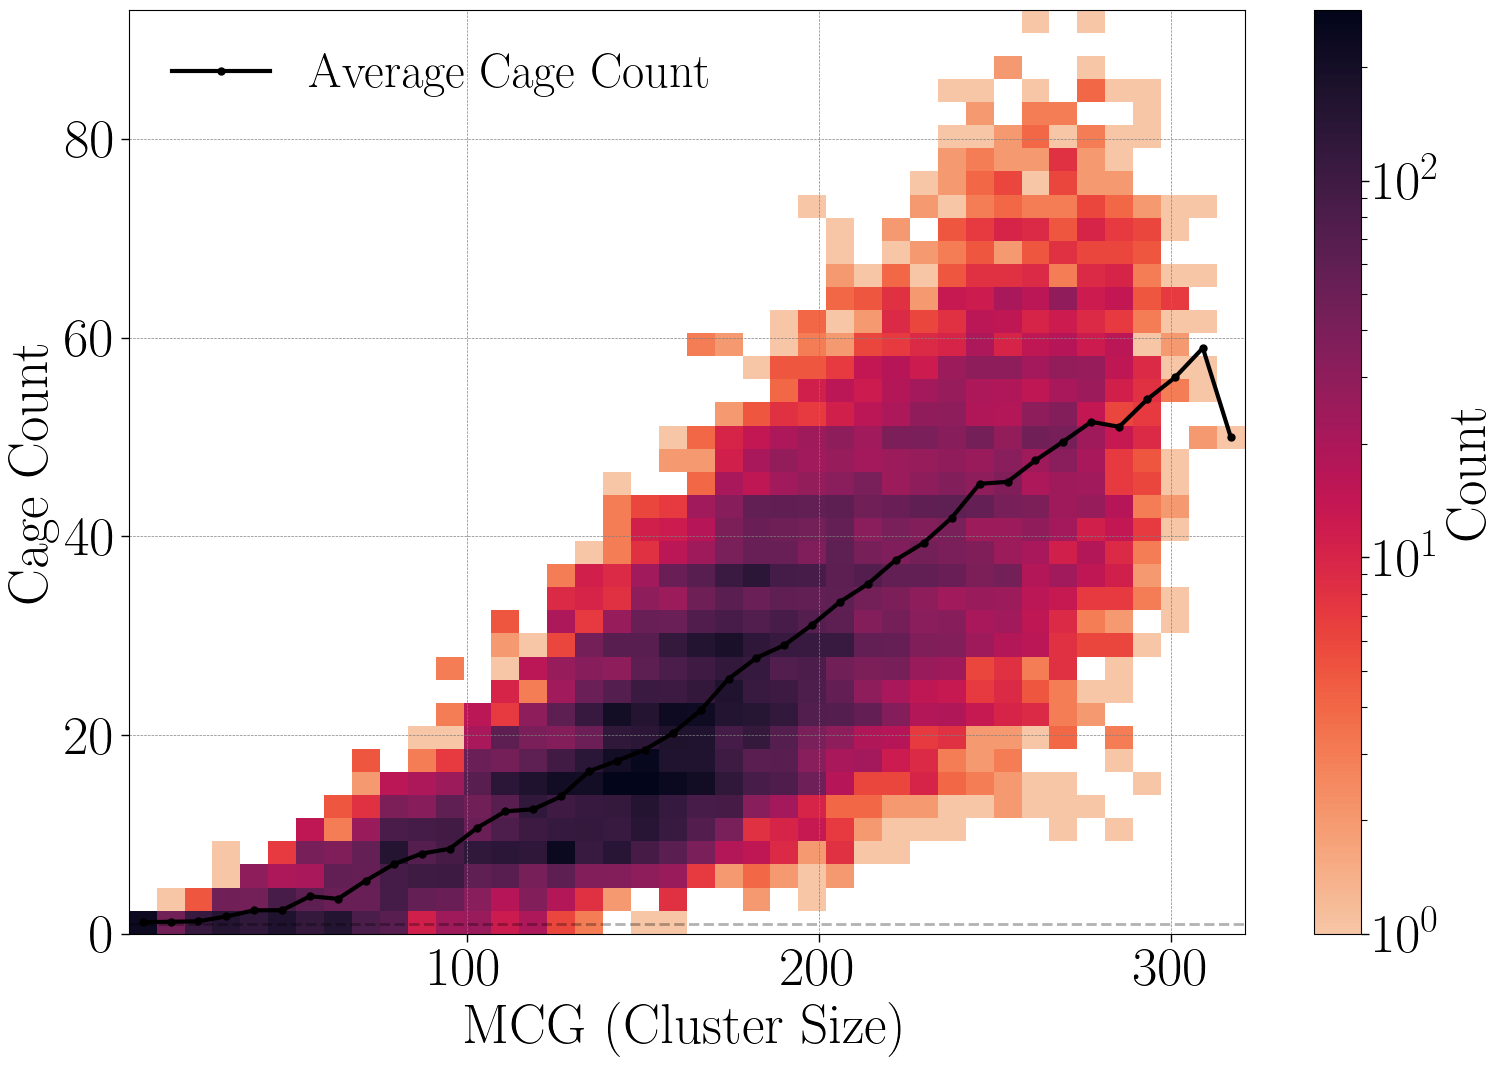

In [24]:
plt.figure(figsize=(18, 12))

masked_counts = np.ma.masked_where(counts_CageCount == 0, counts_CageCount)
X, Y = np.meshgrid(xedges, yedges, indexing="ij")

plt.axhline(y=1, color='k', linestyle='--', alpha=0.3)

plt.pcolormesh(X, Y, masked_counts, cmap=cmap, norm=LogNorm())
plt.plot(xcenters, avg_cage_per_mcg, c = 'black', label = 'Average Cage Count', marker = 'o', ms = 5, lw = 3)


#plt.plot(x, x, color=cfg.colors['red'])
plt.colorbar(label='Count')
plt.xlabel(r'MCG (Cluster Size)')
plt.ylabel(r'Cage Count')
#plt.xlim(0, 60)
#plt.ylim(0, 35)
plt.savefig('figures/cage_count.png')
plt.legend(loc = 'upper left')
plt.show()

In [25]:

chain0_folders =['data_mu175_chain0_batch_0/']

chains = [chain0_folders]

In [26]:
'''
for run_idx in range(12):
    CR_list = []
    run = f'run_{run_idx}'
    for dataset in chain1_folders:
        for idx in run_data[dataset][run]['index_succ'].keys():
            CR = run_data[dataset][run]['index_succ'][idx]['CageRatio']
            #print(dataset, run_idx, idx)
            CR_list.append(CR)

    plt.plot(CR_list)
    plt.axhline(1)
    plt.show()
'''
            

"\nfor run_idx in range(12):\n    CR_list = []\n    run = f'run_{run_idx}'\n    for dataset in chain1_folders:\n        for idx in run_data[dataset][run]['index_succ'].keys():\n            CR = run_data[dataset][run]['index_succ'][idx]['CageRatio']\n            #print(dataset, run_idx, idx)\n            CR_list.append(CR)\n\n    plt.plot(CR_list)\n    plt.axhline(1)\n    plt.show()\n"

In [27]:
plt.rcParams.update({
    'font.size': 18,
    'axes.labelsize': 40,
    'axes.titlesize': 18,
    'xtick.labelsize': 40,
    'ytick.labelsize': 40,
    'legend.fontsize': 14,
    'legend.frameon': False,
    'axes.grid': True
})

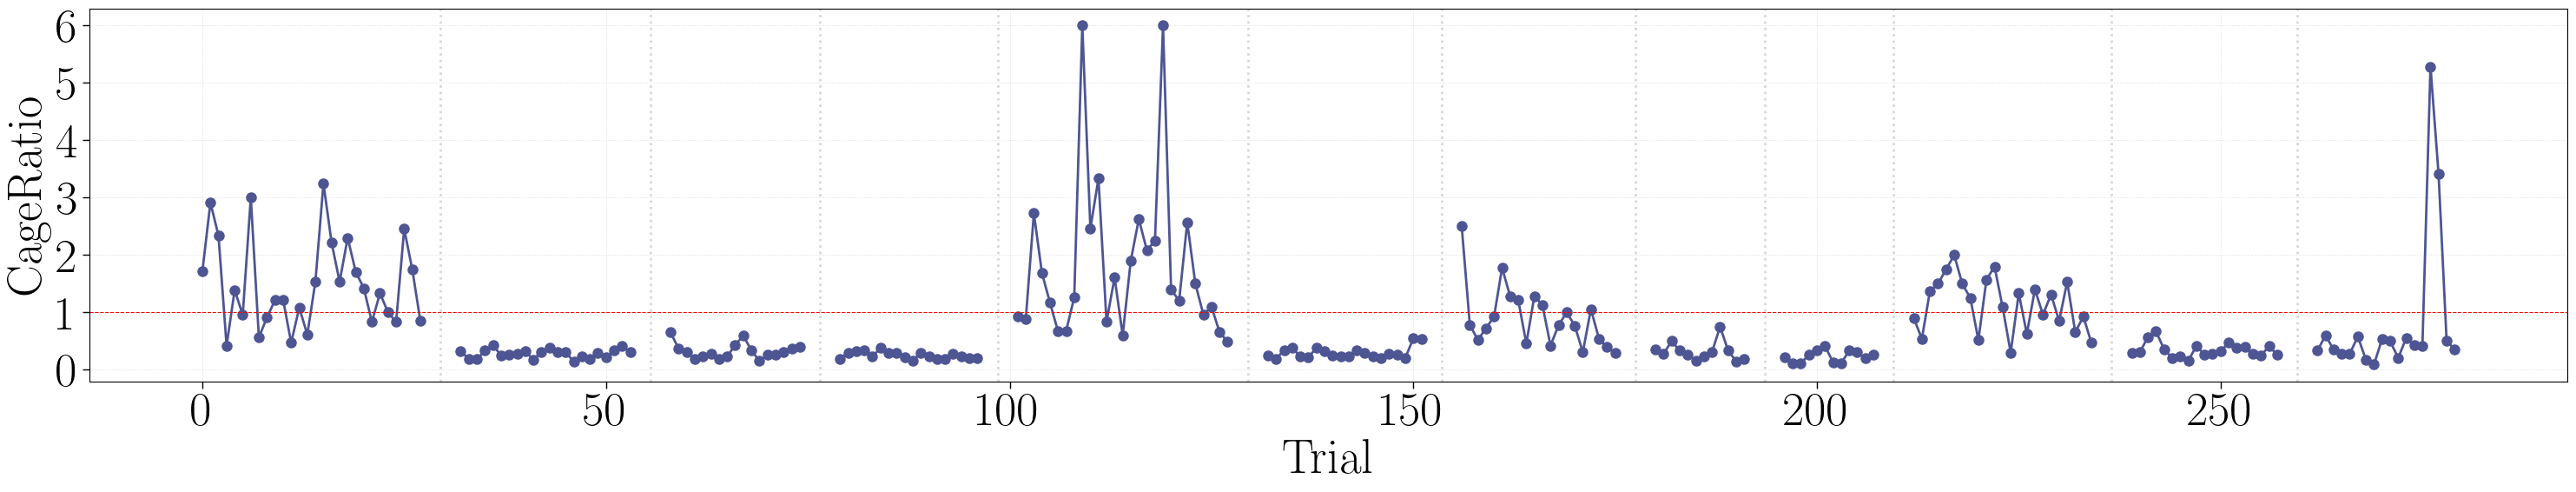

In [28]:

for chainidx, chain in enumerate(chains):

    plt.figure(figsize=(30, 6))
    spacing = 5 
    
    current_x = 0  

    for run_idx in range(12):
        CR_list = []
        run = f'run_{run_idx}'
        #print(run)
        for dataset in chain:
            #print(dataset)
            for idx in sorted(run_data[dataset][run]['index_succ'].keys()):
                #print(idx)
                CR = run_data[dataset][run]['index_succ'][idx]['CageRatio']
                CR_list.append(CR)
        
        x_values = np.arange(len(CR_list)) + current_x
        plt.plot(x_values, CR_list, c = cfg.colors['darkblue'])
        plt.scatter(x_values, CR_list, c = cfg.colors['darkblue'])
        
        current_x = x_values[-1] + spacing if len(x_values) > 0 else current_x + spacing
    
        if run_idx > 0 and len(x_values) > 0:
            plt.axvline(x=x_values[0] - spacing/2, color='gray', linestyle=':', alpha=0.3)

    plt.axhline(1, color='red', linestyle='--', linewidth=0.8)
    plt.xlabel('Trial')
    plt.ylabel('CageRatio')
    ymin, ymax = plt.ylim()
    plt.yticks(np.arange(ymax))
    #plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.savefig(f'figures/cr_per_trial_chain_{chainidx}')
    plt.show()

In [29]:
A2A_cv = []
A2C_cv = []
C2C_cv = []
C2A_cv = []

for chainidx, chain in enumerate(chains):
    print(chain)

    for run_idx in range(12):
        CR_list = []
        run = f'run_{run_idx}'
        print(run)
        for dataset in chain:
            for idx in sorted(run_data[dataset][run]['index_succ'].keys()):
                #print(idx)
                CR = run_data[dataset][run]['index_succ'][idx]['CageRatio']
                SP_MCG = run_data[dataset][run]['index_succ'][idx]['sp_mcg']
                #print(CR)
                if len(CR_list) > 0:
                    if CR_list[-1] < 1 and CR < 1:
                        #print('A2A')
                        A2A_cv.append(SP_MCG)
                    if CR_list[-1] < 1 and CR > 1:
                        #print('A2C')
                        A2C_cv.append(SP_MCG)
                    if CR_list[-1] > 1 and CR > 1:
                        #print('C2C')
                        C2C_cv.append(SP_MCG)
                    if CR_list[-1] > 1 and CR < 1:
                        #print('C2A')
                        C2A_cv.append(SP_MCG)
                CR_list.append(CR)

['data_mu175_chain0_batch_0/']
run_0


KeyError: 'sp_mcg'

In [ ]:
plt.hist(A2A_cv)
plt.hist(A2C_cv)
plt.hist(C2A_cv)
plt.hist(C2C_cv)

In [ ]:
for y_value, transition_cv in enumerate([A2A_cv, A2C_cv, C2C_cv, C2A_cv]):
    
    y = np.full(len(transition_cv), y_value)
    
    plt.scatter(transition_cv, y)

In [ ]:

transitions = ['A2A', 'A2C', 'C2C', 'C2A']
all_cv = [A2A_cv, A2C_cv, C2C_cv, C2A_cv]

In [ ]:
from collections import Counter

In [ ]:
plt.figure(figsize=(10, 6))

for y, (name, cv) in enumerate(zip(transitions, all_cv)):
    counts = Counter(cv)
    
    for val, freq in counts.items():
        plt.scatter(val, y, s=freq*100, alpha=0.7, label=name if val == min(counts) else "")

plt.yticks(range(len(transitions)), transitions)
plt.xlabel('CV Value')
plt.ylabel('Transition Type')
plt.grid(axis='x', linestyle='--', alpha=0.6)

handles, labels = plt.gca().get_legend_handles_labels()

plt.show()